# Data Cleaning Notebook

## Objectives

* Evaluate any missing data
* Clean data
* Conduct a PPS Study
* Split data into Test and Train sets

## Inputs

* <code>outputs/datasets/collection/HousePriceRecords.csv</code>

## Outputs

* Generate cleaned <code>Test</code> and <code>Train</code> sets, both saved under: <code>outputs/datasets/cleaned</code>

* Generate cleaned <HousePriceRecords> data, saved under: <code>outputs/datasets/cleaned</code>

## Additional Comments

* Use the *DropFeatures* feature to drop the variables

* Use the *CategoricalImputer* feature to replace the missing data with the most frequently occuring variable

* Use the *ArbitraryNumberImputer* feature replace the missing variable data with the value of *0*

* Use the *MeanMedianImputer* feature to replace the missing variable data with the median

---

# Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/hertiage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory

* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/hertiage-housing'

## Load Both Datasets

Load House Price Records:

In [6]:
import pandas as pd
df_house_prices = pd.read_csv("outputs/datasets/collection/HousePriceRecords.csv")
print(df_house_prices.shape)
df_house_prices.head()

ModuleNotFoundError: No module named 'pandas'

Load Inherited Houses:

In [5]:
df_inherited_houses = pd.read_csv("outputs/datasets/collection/InheritedHouses.csv")
print(df_inherited_houses.shape)
df_inherited_houses.head()

(4, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


---

## Data Exploration

From the quick display of the data, we can already see that there is missing data in the **HousePriceRecords** Dataset, therefore we will do a more extensive search to see all the variables that contain missing data:

In [6]:
missing_house_price_vars = df_house_prices.columns[df_house_prices.isna().sum() > 0].to_list()
missing_house_price_vars

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [7]:
df_house_prices[missing_house_price_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


In [8]:
from ydata_profiling import ProfileReport
if missing_house_price_vars:
    profile = ProfileReport(df=df_house_prices[missing_house_price_vars], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Next we will generate another Profile Report to check each variable for missing data:

#### Findings:

* We can see that 10 columns have missing data out of the 24 total columns.

* It is a mix of float64 and object data types.

* 13 total alerts: 9 for missing data and 4 with too many zeros, also some of these share the same variables.

Next we will check if there is any missing data in the **InheritedHouses** data:

In [9]:
missing_inherited_vars = df_inherited_houses.columns[df_inherited_houses.isna().sum() > 0].to_list()
missing_inherited_vars

[]

There are no variables with missing data

#### Findings:

* There is no missing data for this Dataset.

--- 

# Data Cleaning


In this section we will:

* Check for missing data levels.

* Determine the best way to impute the data.

* Clean the data.



## Accessing Missing Data Levels

First of all, we will create a function that will allow us to display the total data missing, percentage of the data, as well as the data type:

In [10]:
def EvaluateMissingData(df_house_prices):
    missing_data_full = df_house_prices.isnull().sum()
    percentage_of_missing = round(missing_data_full/len(df_house_prices)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"MissingDataRows": missing_data_full,
                                   "PercentageOfData": percentage_of_missing,
                                   "DataType": df_house_prices.dtypes}
                                    )
                          .sort_values(by=['PercentageOfData'], ascending=False)
                          .query("PercentageOfData > 0")
                          )

    return df_missing_data

EvaluateMissingData(df_house_prices)

,MissingDataRows,PercentageOfData,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


---

#### Findings:

Ideally, we would like to preserve as much data as possible rather than dropping/deleting data, we can assess the best way to impute the missing values.

* **EnclosedPorch** is missing 90.68% of data:

There is a large amount of data missing here, the option we will choose to do here will be to drop the data from the study. This is also because it was it was not one of the variables that were highly correlated against SalePrice.

* **WoodDeckSF** is missing 89.38% of data:

We will choose to employ the same method as above for this variable for the same reason.

* **LotFrontage** is missing 17.74% of data:

After looking the ProfileReport, we can see that due to the skewness and kurtosis the data does not seem to have a normal distribution, therefore the missing data should be imputed using the median.

* **GarageFinish** is missing 16.10% of data:

After looking further into the ProfileReport, we can see that there is different finish types, for this we will fill in the missing data with the most common value.

* **BsmtFinType1** is missing 9.93% of data:

We will choose to employ the same method as above for this variable.

* **BedroomAbvGr** is missing 6.78% of data:

After looking at the ProfileReport, we can see the best imputation to use would be using the median.

* **2ndFlrSF** is missing 5.89% of data:

More than 50% is a 0, which indicates that there is no second floor present, therefore we will impute any missing values with 0.

* **GarageYrBlt** is missing 5.55% of data:

There was a strong correlation between GarageArea and SalePrice, we will therefore assume that the Year the Garage was built should be taken into account, and we will therefore use the median to impute the data.

* **BsmtExposure** is missing 2.60% of data:

After looking further into the ProfileReport, we can see that there is different exposures, for this we will fill in the missing data with the most common value.

* **MasVnrArea** is missing 0.55% of data:

The majority of values are 0, which indicates that there is no masonry veneer area present, therefore we will impute any missing values with 0.

#### Conclusion:

* **EnclosedPorch** and **WoodDeckSF** = drop the data

* **LotFrontage**, **BedroomAbvGr**, and **GarageYrBlt** = median value

* **GarageFinish**, **BsmtFinType1**, and **BsmtExposure** = common value

* **2ndFlrSF** and **MasVnrArea** = 0 value

## Replace Missing Data

First we will create a **Pipeline** so that we can:

* Use the DropFeatures feature to drop the variables mentioned above.

* Use the CategoricalImputer feature to replace the missing data with the most frequently occuring variable.

* Use the ArbitraryNumberImputer feature replace the missing variable data with the value of 0.

* Use the MeanMedianImputer feature to replace the missing variable data with the median.

In [11]:
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from sklearn.pipeline import Pipeline

dropped_features = ['EnclosedPorch', 'WoodDeckSF']
categorical_features = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
arbitrary_features = ['2ndFlrSF', 'MasVnrArea']
median_features = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']

pipeline = Pipeline([
    ('DropFeatures', DropFeatures(features_to_drop=dropped_features)),

    ('CategoricalImputer', CategoricalImputer(imputation_method='frequent', variables=categorical_features)),

    ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=arbitrary_features)),

    ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=median_features)),


])

df_house_prices = pipeline.fit_transform(df_house_prices)

Next we will check whether all the data has been cleaned using the same function from earlier:

In [12]:
def EvaluateCleanedData(df_house_prices):
    missing_data_full = df_house_prices.isnull().sum()
    percentage_of_missing = round(missing_data_full/len(df_house_prices)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"MissingDataRows": missing_data_full,
                                   "PercentageOfData": percentage_of_missing,
                                   "DataType": df_house_prices.dtypes}
                                    )
                          .sort_values(by=['PercentageOfData'], ascending=False)
                          .query("PercentageOfData > 0")
                          )

    return df_missing_data

EvaluateCleanedData(df_house_prices)

,MissingDataRows,PercentageOfData,DataType


As we can see there is now no missing data.

---

## PPS Analysis & Correlation Study

Now that we have cleaned the data, we will perform a PPS Analysis and further correlation study. The reason for this is because we would like to find out how the target variable of SalePrice correlates with the features:

* We will use the same pearson and spearman methods for correlation
* We will also calculate the Power Predictive Score (PPS).
* We will also check for the best predictors.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

%matplotlib inline

def heatmap_corr(df_house_prices, threshold, figsize=(20, 12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool_)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df_house_prices) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df_house_prices, rotation=0)
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()



def heatmap_pps(df_house_prices, threshold, figsize=(20, 12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool_)
        mask[abs(df_house_prices) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r',
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))


    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df_house_prices=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df_house_prices=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df_house_prices=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [14]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_house_prices)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.061  0.105  0.0  0.0  0.0  0.083  0.625




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



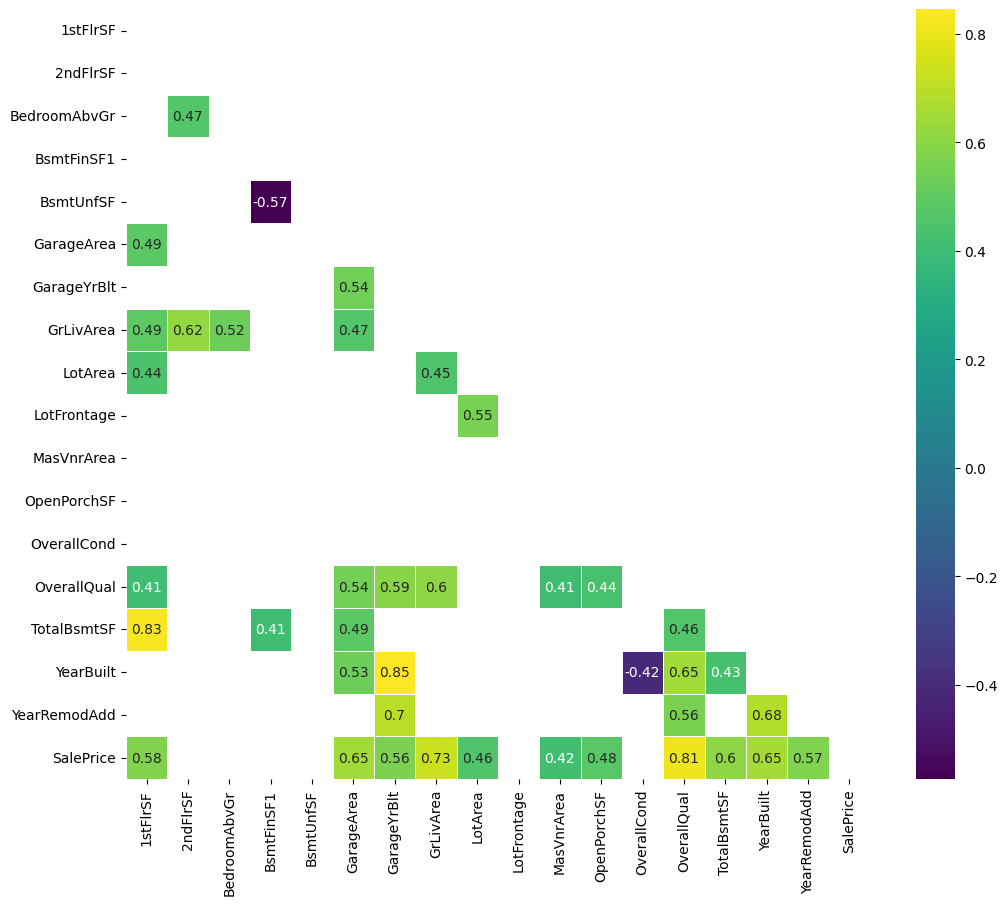



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



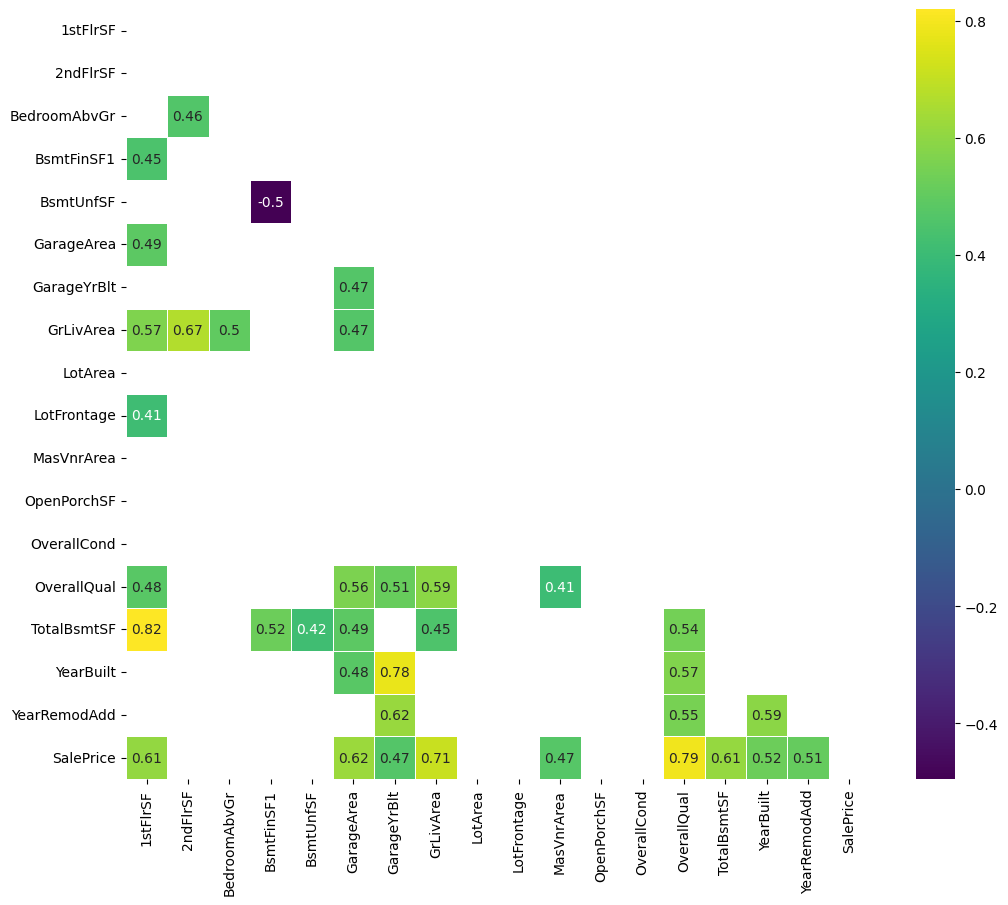



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



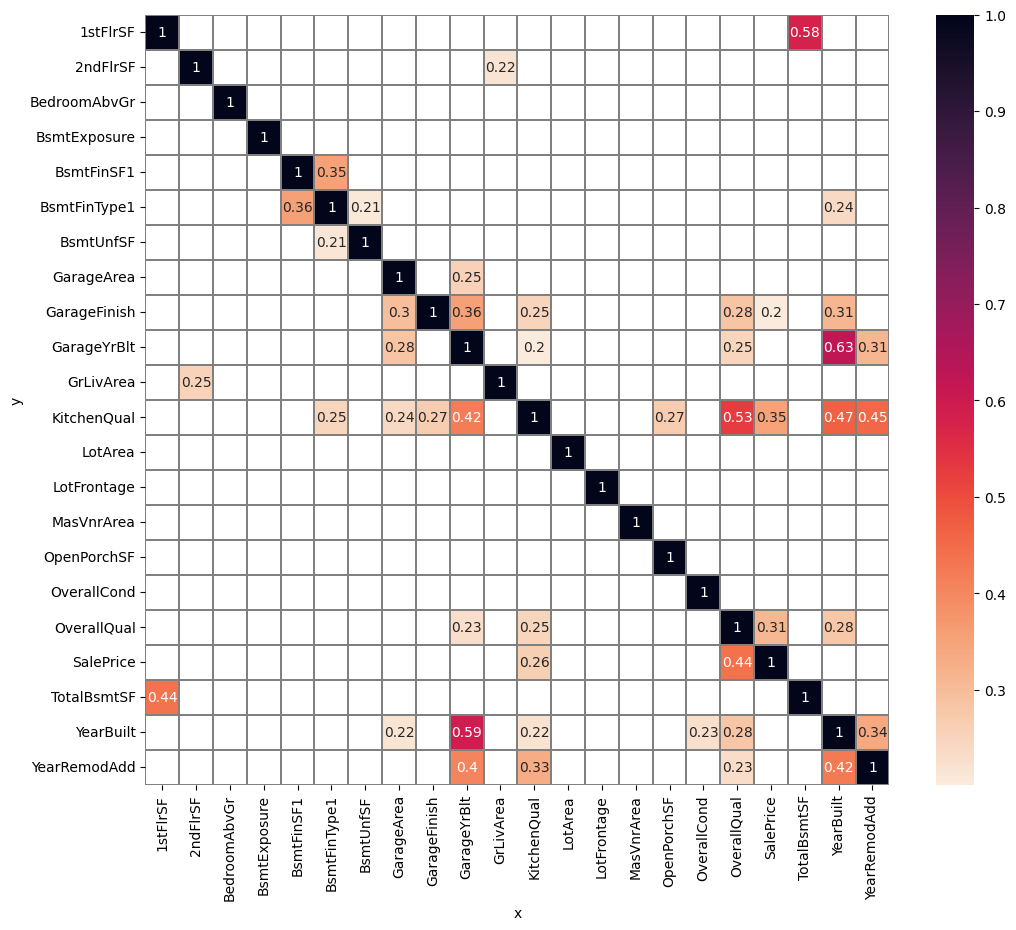

In [15]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

* Analyse how the target variable for your ML models are correlated with other variables (features and target)

* Analyse multi-colinearity, that is, how the features are correlated among themselves

*** Heatmap: Spearman Correlation ***

It evaluates monotonic relationship 

/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


*** Heatmap: Pearson Correlation ***

It evaluates the linear relationship between two continuous variables 

*** Heatmap: Power Predictive Score (PPS) ***

PPS detects linear or non-linear relationships between two columns.

The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 

In [16]:
pps.predictors(df_house_prices, "SalePrice")

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,OverallQual,SalePrice,0.440962,regression,True,mean absolute error,55533.656164,31045.438267,DecisionTreeRegressor()
1,KitchenQual,SalePrice,0.261966,regression,True,mean absolute error,55533.656164,40985.702734,DecisionTreeRegressor()
2,YearBuilt,SalePrice,0.198485,regression,True,mean absolute error,55533.656164,44511.073059,DecisionTreeRegressor()
3,GarageArea,SalePrice,0.187993,regression,True,mean absolute error,55533.656164,45093.723468,DecisionTreeRegressor()
4,GarageYrBlt,SalePrice,0.158649,regression,True,mean absolute error,55533.656164,46723.306998,DecisionTreeRegressor()
5,YearRemodAdd,SalePrice,0.143284,regression,True,mean absolute error,55533.656164,47576.566795,DecisionTreeRegressor()
6,GarageFinish,SalePrice,0.120717,regression,True,mean absolute error,55533.656164,48829.810829,DecisionTreeRegressor()
7,GrLivArea,SalePrice,0.100166,regression,True,mean absolute error,55533.656164,49971.091218,DecisionTreeRegressor()
8,BsmtFinType1,SalePrice,0.086540,regression,True,mean absolute error,55533.656164,50727.759629,DecisionTreeRegressor()
9,LotFrontage,SalePrice,0.066151,regression,True,mean absolute error,55533.656164,51860.037068,DecisionTreeRegressor()


### Findings:

* There are a number of variables showing a moderate-strong correlation between other variables.

* We are however interested in the correlation of variables against SalePrice"
   * We have noticed that the strongest contendor is OverallQual of a property.
   * Overall from the study and the previous correlation study the most strongly 6 correlated features were:
       * 1stFlrSF
       * GarageArea
       * GrLivArea
       * OverallWual
       * TotalBsmtSF
       * YearBuilt
* We can also see from the pps.predictors that the best case to use would be regression and it suggests using a **DecisionTreeRegressor** model, however we will conduct a study to find the most effective model to use in the Feature Engineering notebook.

---

# Split Train and Test Set

Next we will split our data into Train and Test sets, and then check for any missing data:

In [17]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_house_prices,
                                        df_house_prices['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 22) 
TestSet shape: (292, 22)


In [18]:
EvaluateCleanedData(TrainSet)

,MissingDataRows,PercentageOfData,DataType


We can see the the TrainSet has no missing data.

---

# Push files to Repo

## Train Set

In [20]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

In [21]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


## Test Set

In [22]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

## House Prices


In [23]:
df_house_prices.to_csv("outputs/datasets/cleaned/HousePriceRecordsCleaned.csv", index=False)

---

## Next Steps

* To complete feature engineering for a regression model.

---